<a href="https://colab.research.google.com/github/jaekyoungkim/floor_DL/blob/main/%EB%B0%91%EB%B0%94%EB%8B%A5%EB%B6%80%ED%84%B0%EC%8B%9C%EC%9E%91%ED%95%98%EB%8A%94%EB%94%A5%EB%9F%AC%EB%8B%9D2_(ch5_8).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/WegraLee/deep-learning-from-scratch-2.git

Cloning into 'deep-learning-from-scratch-2'...
remote: Enumerating objects: 606, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 606 (delta 1), reused 5 (delta 0), pack-reused 598
Receiving objects: 100% (606/606), 29.82 MiB | 51.66 MiB/s, done.
Resolving deltas: 100% (361/361), done.


# ch5. 순환신경망(RNN) 

In [ ]:
# feedforward 신경망 : 흐름이 단방향인 신경망, 입력신호가 다음층으로 전달되고 그 신호를 받은 층은 그 다음층으로 전달
# feedforward는 구성이 단순하여 구조를 이해하기 쉽고, 많은 문제에 응용할 수 있음
# 커다란 단점이 있으니, 바로 시계열 데이터를 잘 다루지 못함
# 시계열 데이터의 성질을 충분히 학습할 수 없음 -> RNN등장

In [ ]:
# 확률과 언어모델 
# 언어모델(Language model):단어 나열에 확률을 부여함, 특정한 단어의 시퀀스에 대해서 스 시퀀스가 일어날 가능성을 평가
# 이상적으로는 맥락의 단어 순서도 모델이 고려해야함 
# CBOW에서는 맥락의 단어 벡터를 은닉층에서 연결하는 방식을 생각해볼 수도있음
# 그러나 연결하는 방식을 취하면 맥락의 크기에 비례해 가중치 매개변수도 늘어나게됨


In [2]:
# 순환하는 신경망 RNN
# 순환하기 위해서는 닫힌 경로가 필요함 , 닫힌경로 혹은 순환하는 경로가 존재해야 데이터가 같은 장소를 반복해 왕래
# 데이터가 순환하면서 정보가 끊임없이 갱신됨
# RNN의 특징은 순환하는 경로가 있다는 것, 이 순환경로를 따라 데이터는 끊임없이 순환
# 데이터가 순환되기 때문에 과거의 정보를 기억하는 동시에 최신 데이터로 갱신가능
# h_{t} = tanh( h_{t-1} W_{h} + x_{t} * W_{x} +b )
# h_{t}(현재의 출력)은 한 시각 이전 출력(h_{t-1})에 기초해 계산됨
# RNN은 h라는 상태를 가지고 있으며, 즉 상태를 가지는 계층, 메모리가 있는 계창이라고 함
# h_{t}를 은닉상태 혹은 은닉 상태 벡터라고 부름


In [3]:
# BPTT (backpropagation through time) 
# 시계열 데이터의 시간크기가 커지는 것에 비례하여 BPTT가 소비하는 컴퓨팅자원도 증가함
# 시간 크기가 커지면 역전파 시의 기울기가 불안정해지는것도 문제임
# BPTT를 이용해 기울기를 구하려면 매 시각RNN 계층의 중간 데이터를 메모리에 유지해두지 않으면 안됨

In [4]:
# Truncated BPTT
# 너무 길어진 신경망을 적당한 지점에서 잘라내어 작은 신경망 여러개로 만드는 아이디어
# 제대로 구현하려면 역전파의 연결만 끊음/순전파의 연결은 반드시 그대로 유지
# 계층이 길어짐에 따라 신경망을 하나 통과할때마다 기울기 값이 조금씩 작아져서, 이전시각 T까지 연전파 되기전에 0이될가능성있음

In [9]:
class RNN:
  def __init__(self, Wx, Wh, b): # 가중치 2개와 편향1개를 인수로 받음
    self.params = [Wx, Wh, b] 
    self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)] 
    self.cache = None # 역전파 계산시 사용하는 중간 데이터를 담는역할
  
  def  forward(self, x, h, h_prev): 
    Wx, Wh, b = self.params 
    t= np.matmul(h_prev, Wh) + np.matmul(x, Wx) + b
    h_next = np.tanh(t) 
    self.cache = (x,h_prev,h_next) 
    return h_next
  
  def backward(self, dh_next):
    Wx, Wh, b = self.params 
    x, h_prev, h_next = self.cache 

    dt = dh_next * (1- h_next**2)  # tanh의 역함수
    db = np.sum(dt, axis=0) 
    dWh = np.matmul(h_prev.T, dt) 
    dh_prev = np.matmul(dt, Wh.T)
    dWx = np.matmul(x.T, dt) 
    dx = np.matmul(dt, Wx.T) 

    self.grads[0][...] = dWx
    self.grads[1][...] = dWh
    self.grads[2][...] = db

    return dx, dh_prev

In [10]:
# TimeRNN
# 시계열 데이터를 한꺼번에 처리하는 계층
# T개분의 시계열 데이터를 한꺼번에 처리하는 계층
# RNN계층의 은닉상태를 TimeRNN계층에서 관리하기로함
# RNN계층 사이에서 은닉상태를 인계하는 작업을 생각하지 않아도 되는 장점
class TimeRNN:
  def __init__(self, Wx, Wh, b, stateful=False):
    self.params = [Wx, Wh, b] 
    self.grads = [np.zeros_like(Wx) , np.zeros_like(Wh), np.zeros_like(b)] 
    self.layers = None 

    self.h, self.dh = None, None
    self.stateful = stateful 
  
  def set_state(self, h):
    self.h = h

  def reset_state(self): 
    self.h = None 

In [3]:
# RNNLM학습과 평가
import sys 
sys.path.append('/content/deep-learning-from-scratch-2/')
import numpy as np
from common.time_layers import *

In [6]:
class SimpleRnnlm: 
  def __init__(self, voca_size, wordvec_size, hidden_size): 
    V,D,H = vocab_size, wordvec_size, hidden_size 
    rn = np.random.randn 

    # 가중치 초기화 : xavier초깃값을 사용 / 이전 계층의 노드가 n개라면 표준편차가 1/roo(n) 인 분포로 초기화
    embed_W = (rn(V,D) / 100).astype('f') 
    rnn_Wx = (rn(D,H) / np.sqrt(D)).astype('f')
    rnn_Wh = (rnn(H,H) /np.sqrt(H)).astype('f') 
    rnn_b = np.zeros(H).astype('f') 
    affine_W = (rn(H,V) / np.sqrt(H)).astype('f') 
    affine_b = np.zeros(V).astype('f') 

    # 계층 생성
    self.layers = [TimeEmbedding(embed_W), TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
                   TimeAffine(affine_W,  affine_b)]
    # truncated BPTT로 학습한다고 가정하여 Stateful = True로 설정 : 이전은닉상태를 계승할 수 있음
    self.loss_layer = TImesoftmaxWithLoss()
    self.rnn_layer = self.layers[1]
    
    # 모든 가중치와 기울기를 리스트에 모으기
    self.params, self.grads = [], [] 
    for layer in self.layers :
      self.params += layer.params 
      self.grads += layer.grads 
  
  def forward(self, xs, ts):
    for layer in self.layers:
      xs = layer.forward(xs) 
    loss = self.loss_layer.forward(xs, ts)

  def backward(self, dout=1):
    dout = self.loss_layer.backward(dout) 
    for layer in reversed(self.layers):
      dout = layer.backward(dout) 
    return dout 

  def rest_state(self):
    self.rnn_layer.reset_state() 




In [61]:
# 언어모델의 평가방법 : perplexity (혼란도) 
# 확률의 역수
# you say good bye -> you 다음 단어 say나올확률이 0.8 이라면 1/0.8=1.25가 perplexity
# 혼란도는 작을수록 좋음
# 혼란도는 분기수라고 해석할수 있음(number of branches)
# 다음에 취할 수 있는 선택사항의 수


In [72]:
# RNNLM학습코드
import matplotlib.pyplot as plt
from common.optimizer import SGD
from dataset import ptb 
from ch05.simple_rnnlm import SimpleRnnlm
#하이퍼 파라미터설정
batch_size =10
wordvec_size =100
hidden_size =100 
time_size =5 # truncated bptt가 한번에 펼치는 시간 크기
lr = 0.1
max_epoch = 100

# 학습데이터 읽기
corpus , word_to_id, id_to_word  = ptb.load_data("train")
corpus_size =1000
corpus = corpus[:corpus_size] 
vocab_size = int(max(corpus) +1)

In [73]:
corpus

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        27,  24,  39,  26,  40,  41,  42,  26,  43,  32,  44,  45,  46,
        24,  47,  26,  27,  28,  29,  48,  49,  41,  42,  50,  51,  52,
        53,  54,  55,  35,  36,  37,  42,  56,  57,  58,  59,  24,  35,
        60,  42,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  35,
        71,  72,  42,  73,  74,  75,  35,  46,  42,  76,  77,  64,  78,
        79,  80,  27,  28,  81,  82,  83,  24,  32,  61,  84,  26,  40,
        85,  26,  62,  78,  86,  32,  26,  87,  88,  89,  90,  64,  78,
        91,  92,  93,  94,  95,  96,  97,  82,  98,  24,  26,  99,  32,
       100,  42, 101, 102,  26, 103,  93, 104,  66, 105, 106, 107,  26,
       108, 109,  26,  67,  68, 108,  27,  24, 110, 111, 112, 113,  83,
        79,  80,  35, 114,  81,  32, 115, 116, 117, 108, 118, 11

In [74]:
len(corpus)

1000

In [75]:
vocab_size # 76

418

In [76]:
xs = corpus[:-1];xs

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        27,  24,  39,  26,  40,  41,  42,  26,  43,  32,  44,  45,  46,
        24,  47,  26,  27,  28,  29,  48,  49,  41,  42,  50,  51,  52,
        53,  54,  55,  35,  36,  37,  42,  56,  57,  58,  59,  24,  35,
        60,  42,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  35,
        71,  72,  42,  73,  74,  75,  35,  46,  42,  76,  77,  64,  78,
        79,  80,  27,  28,  81,  82,  83,  24,  32,  61,  84,  26,  40,
        85,  26,  62,  78,  86,  32,  26,  87,  88,  89,  90,  64,  78,
        91,  92,  93,  94,  95,  96,  97,  82,  98,  24,  26,  99,  32,
       100,  42, 101, 102,  26, 103,  93, 104,  66, 105, 106, 107,  26,
       108, 109,  26,  67,  68, 108,  27,  24, 110, 111, 112, 113,  83,
        79,  80,  35, 114,  81,  32, 115, 116, 117, 108, 118, 11

In [77]:
ts = corpus[1:];ts

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  27,
        24,  39,  26,  40,  41,  42,  26,  43,  32,  44,  45,  46,  24,
        47,  26,  27,  28,  29,  48,  49,  41,  42,  50,  51,  52,  53,
        54,  55,  35,  36,  37,  42,  56,  57,  58,  59,  24,  35,  60,
        42,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  35,  71,
        72,  42,  73,  74,  75,  35,  46,  42,  76,  77,  64,  78,  79,
        80,  27,  28,  81,  82,  83,  24,  32,  61,  84,  26,  40,  85,
        26,  62,  78,  86,  32,  26,  87,  88,  89,  90,  64,  78,  91,
        92,  93,  94,  95,  96,  97,  82,  98,  24,  26,  99,  32, 100,
        42, 101, 102,  26, 103,  93, 104,  66, 105, 106, 107,  26, 108,
       109,  26,  67,  68, 108,  27,  24, 110, 111, 112, 113,  83,  79,
        80,  35, 114,  81,  32, 115, 116, 117, 108, 118, 119, 10

In [78]:
data_size = len(xs) 
print('말뭉치크기 :%d, 어휘수 : %d'% (corpus_size, vocab_size))

말뭉치크기 :1000, 어휘수 : 418


In [79]:
max_iters = data_size // (batch_size* time_size) ;max_iters #  // 몫만 나옴

19

In [80]:
time_idx = 0
total_loss= 0
loss_count= 0
ppl_list =[]


In [81]:
#모델생성
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size) 
optimizer= SGD(lr)

In [82]:
jump = (corpus_size -1) // batch_size ; jump

99

In [83]:
offsets = [i * jump for i in range(batch_size)] ;offsets
# 데이터를 읽기 시작하는 위치

[0, 99, 198, 297, 396, 495, 594, 693, 792, 891]

In [84]:
for epoch in range(max_epoch):
  for iter in range(max_iters):
    batch_x = np.empty((batch_size, time_size) , dtype = 'i')
    batch_t = np.empty((batch_size, time_size) , dtype = 'i')
    for t in range(time_size): 
      for i, offset in enumerate(offsets): 
        batch_x[i,t] = xs[(offset+time_idx) % data_size]
        batch_t[i,t] = ts[(offset+time_idx) % data_size]
      time_idx += 1 
    
    # 기울기를 구하여 매개변수 갱신
    loss = model.forward(batch_x, batch_t) 
    model.backward() 
    optimizer.update(model.params, model.grads)
    total_loss += loss 
    loss_count += 1

  
  # 에폭마다 퍼플렉시티 평가
  ppl = np.exp(total_loss / loss_count) 
  print('에폭  %d : 퍼플렉시티 : %.2f'% (epoch+1, ppl))
  ppl_list.append(float(ppl))
  total_loss, loss_count = 0,0 

에폭  1 : 퍼플렉시티 : 367.58
에폭  2 : 퍼플렉시티 : 240.71
에폭  3 : 퍼플렉시티 : 218.79
에폭  4 : 퍼플렉시티 : 212.52
에폭  5 : 퍼플렉시티 : 204.71
에폭  6 : 퍼플렉시티 : 201.40
에폭  7 : 퍼플렉시티 : 198.36
에폭  8 : 퍼플렉시티 : 196.15
에폭  9 : 퍼플렉시티 : 191.70
에폭  10 : 퍼플렉시티 : 193.31
에폭  11 : 퍼플렉시티 : 189.69
에폭  12 : 퍼플렉시티 : 192.35
에폭  13 : 퍼플렉시티 : 190.70
에폭  14 : 퍼플렉시티 : 190.84
에폭  15 : 퍼플렉시티 : 190.35
에폭  16 : 퍼플렉시티 : 186.66
에폭  17 : 퍼플렉시티 : 184.52
에폭  18 : 퍼플렉시티 : 181.39
에폭  19 : 퍼플렉시티 : 182.73
에폭  20 : 퍼플렉시티 : 183.42
에폭  21 : 퍼플렉시티 : 182.03
에폭  22 : 퍼플렉시티 : 178.09
에폭  23 : 퍼플렉시티 : 175.23
에폭  24 : 퍼플렉시티 : 176.35
에폭  25 : 퍼플렉시티 : 174.85
에폭  26 : 퍼플렉시티 : 176.07
에폭  27 : 퍼플렉시티 : 170.54
에폭  28 : 퍼플렉시티 : 168.82
에폭  29 : 퍼플렉시티 : 166.02
에폭  30 : 퍼플렉시티 : 160.37
에폭  31 : 퍼플렉시티 : 161.62
에폭  32 : 퍼플렉시티 : 157.35
에폭  33 : 퍼플렉시티 : 158.20
에폭  34 : 퍼플렉시티 : 150.91
에폭  35 : 퍼플렉시티 : 150.37
에폭  36 : 퍼플렉시티 : 145.22
에폭  37 : 퍼플렉시티 : 140.26
에폭  38 : 퍼플렉시티 : 140.20
에폭  39 : 퍼플렉시티 : 131.90
에폭  40 : 퍼플렉시티 : 128.22
에폭  41 : 퍼플렉시티 : 129.28
에폭  42 : 퍼플렉시티 : 121.13
에

| 에폭 1 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 416.17
| 에폭 2 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 386.21
| 에폭 3 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 267.26
| 에폭 4 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 222.67
| 에폭 5 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 211.44
| 에폭 6 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 210.26
| 에폭 7 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 201.32
| 에폭 8 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 200.22
| 에폭 9 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 195.65
| 에폭 10 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 190.39
| 에폭 11 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 193.55
| 에폭 12 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 189.58
| 에폭 13 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 192.75
| 에폭 14 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 187.18
| 에폭 15 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 186.85
| 에폭 16 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 191.16
| 에폭 17 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 189.19
| 에폭 18 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 184.39
| 에폭 19 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 180.28
| 에폭 20 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 181.61
| 에폭 21 |  반복 1 / 19 | 시간 2[s] | 퍼플렉서티 178.34
| 에폭 22 |  반복 1 / 19 | 시간 2[s] | 퍼플렉서티 176.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54140 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47113 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49436 missing from current font.
  font.set_

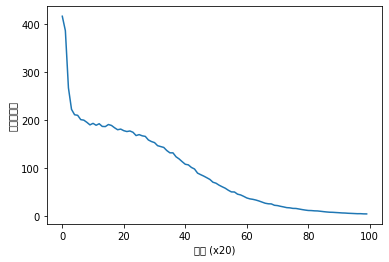

In [85]:
# coding: utf-8
from common.trainer import RnnlmTrainer

# 모델 생성
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

trainer.fit(xs, ts, max_epoch, batch_size, time_size)
trainer.plot()

# model / optimizer를 주어 초기화함
# fit() 메서드를 호출해 학습을 수행함
# 미니배치를 순차적으로 만들고, 모델의 순전파와 역전파를 호출하고 옵티마이저로 가중치를 계산


In [86]:
time_size

5

In [87]:
batch_size

10

In [88]:
xs

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        27,  24,  39,  26,  40,  41,  42,  26,  43,  32,  44,  45,  46,
        24,  47,  26,  27,  28,  29,  48,  49,  41,  42,  50,  51,  52,
        53,  54,  55,  35,  36,  37,  42,  56,  57,  58,  59,  24,  35,
        60,  42,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  35,
        71,  72,  42,  73,  74,  75,  35,  46,  42,  76,  77,  64,  78,
        79,  80,  27,  28,  81,  82,  83,  24,  32,  61,  84,  26,  40,
        85,  26,  62,  78,  86,  32,  26,  87,  88,  89,  90,  64,  78,
        91,  92,  93,  94,  95,  96,  97,  82,  98,  24,  26,  99,  32,
       100,  42, 101, 102,  26, 103,  93, 104,  66, 105, 106, 107,  26,
       108, 109,  26,  67,  68, 108,  27,  24, 110, 111, 112, 113,  83,
        79,  80,  35, 114,  81,  32, 115, 116, 117, 108, 118, 11

In [89]:
ts

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  27,
        24,  39,  26,  40,  41,  42,  26,  43,  32,  44,  45,  46,  24,
        47,  26,  27,  28,  29,  48,  49,  41,  42,  50,  51,  52,  53,
        54,  55,  35,  36,  37,  42,  56,  57,  58,  59,  24,  35,  60,
        42,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  35,  71,
        72,  42,  73,  74,  75,  35,  46,  42,  76,  77,  64,  78,  79,
        80,  27,  28,  81,  82,  83,  24,  32,  61,  84,  26,  40,  85,
        26,  62,  78,  86,  32,  26,  87,  88,  89,  90,  64,  78,  91,
        92,  93,  94,  95,  96,  97,  82,  98,  24,  26,  99,  32, 100,
        42, 101, 102,  26, 103,  93, 104,  66, 105, 106, 107,  26, 108,
       109,  26,  67,  68, 108,  27,  24, 110, 111, 112, 113,  83,  79,
        80,  35, 114,  81,  32, 115, 116, 117, 108, 118, 119, 10

# ch6 . 게이트가 추가된 RNN 


In [90]:
# RNN의 문제 : 시간적으로 멀리 떨어진, 장기 의존 관계를 잘 학습할 수 없음
# RNN대신 LSTM, GRU라는 계층이 주로 사용됨
# LSTM,GRU는 GATE라는 구조가 더해져 있음
# 이 게이트 덕분에 시계열 데이터의 장기 의존관계를 학습 가능
# RNN의 큰 문제점 : 기울기 소실 또는 기울기 폭발

In [93]:
import numpy as np
import matplotlib.pyplot as plt 
N= 2 # 미니배치 크기
H = 3 # 은닉상태 벡터의 차원수
T= 20 # 시계열 데이터의 길이
dh = np.ones((N,H)) 
np.random.seed(3) 
Wh = np.random.randn(H,H) # 3X3
norm_list = [] 
for t in range(T):
  dh = np.matmul(dh,Wh.T) 
  norm = np.sqrt(np.sum(dh**2)) / N
  norm_list.append(norm)

In [94]:
norm_list
# 기울기 폭발이 일어남-> 오버플로우 -> nan값 발생

[2.4684068094579303,
 3.335704974161037,
 4.783279375373183,
 6.2795873320876145,
 8.080776465019055,
 10.25116303229294,
 12.9360635066099,
 16.276861327786712,
 20.454829618345983,
 25.688972842084684,
 32.25315718048336,
 40.48895641683869,
 50.824407307019094,
 63.79612654485427,
 80.07737014308985,
 100.51298922051251,
 126.16331847536827,
 158.3592064825883,
 198.77107967611957,
 249.495615421267]

In [96]:
import numpy as np
import matplotlib.pyplot as plt 
N= 2 # 미니배치 크기
H = 3 # 은닉상태 벡터의 차원수
T= 20 # 시계열 데이터의 길이
dh = np.ones((N,H)) 
np.random.seed(3) 
Wh = np.random.randn(H,H) * 0.5 # 3X3
norm_list = [] 
for t in range(T):
  dh = np.matmul(dh,Wh.T) 
  norm = np.sqrt(np.sum(dh**2)) / N
  norm_list.append(norm)
norm_list
# 기울기 손실 -> 가중치 매개변수가 더이상 갱신 안됨 -> 장기 의존관계를 학습할수 없음

[1.2342034047289652,
 0.8339262435402592,
 0.5979099219216478,
 0.3924742082554759,
 0.25252426453184545,
 0.16017442237957719,
 0.10106299614538984,
 0.06358148956166684,
 0.039950839098332,
 0.025086887541098325,
 0.015748611904532892,
 0.009884999125204758,
 0.006204151282595104,
 0.003893806551809953,
 0.002443767399386287,
 0.0015337065005571367,
 0.0009625497320203268,
 0.0006040924319556743,
 0.00037912574706291117,
 0.00023793756048323344]

In [ ]:
# 기울기 소실/폭발  발생이유 : Wh를 T번 반복해서 곱했기 때문임

In [98]:
# 기울기 폭발 대책
# 기울기 클리핑(Clipping)  : 문턱을 통과하면 기울기를 수정해줌
dW1 = np.random.rand(3,3)*10 ;dW1 
dW2 = np.random.rand(3,3)*10 ;dW2

array([[9.75995422, 6.72383676, 9.02834109],
       [8.45750871, 3.77994041, 0.92217009],
       [6.53410903, 5.57840762, 3.61564763]])

In [101]:
grads= [dW1,dW2] 
max_norm = 5
def clip_grads(grads, max_norm): 
  total_norm = 0
  for grad in grads : 
    total_norm += np.sum(grad**2) 
  
  total_norm = np.sqrt(total_norm )

  rate = max_norm / (total_norm +1e-6) 

  if rate < 1: 
    for grad in grads : 
      grad *= rate

In [100]:
# 기울기 소실과 LSTM 
# 게이트가 추가된 RNN이 나오게된 배경
# LSTM으로 기울기 소실 극복
# RNN에 기억셀 C가 추가됨(LSTM전용의 기억 메커니즘)
# 기억셀 : 데이터를 자기 자신으로만 주고받는것
# LSTM게층 내에서만 완결되고 다른 계층으로는 출력하지 않는것
# Ct : 시각 t에서의 LSTM의 기억이 저장, 과거로부터 시간 t까지에 필요한 모든 정보가 저장돼잇다고 가정함(그렇게 되도록 학습)
# 필요한 정보를 모두 간직한 이 기억을 바탕으로 외부 계층에 은닉상태 h_{t}를 출력
# 이때 출력하는 h_{t} 는 기억셀의 값을tanh함수로 변환한값
# Ct : C_{t-1}, h_{t-1}, x_{t} 가 입력으로 들어감
# 갱신된 Ct를 사용해 은닉상태 h_{t} 계산
# LSTM의 게이트는 열닫 뿐만 아니라 어느정도 열지를 조절 가능 
# 게이트를 얼마나 열까라는 것도 데이터로부터 자동으로 학습하게됨
# tanh(Ct) 에 게이트를 적용하게됨 / tanh(Ct)의 각 원소들이 다음 은닉상태에 얼마나 중요한가를 조정함
# 열림상태는 입력 x_{t}, h_{t-1}로부터 구함
# forget게이트 : 기억셀에 무엇을 잊을까를 지시해야함
# C_{t-1}에서 불필요한 기억을 잊게 해주는 게이트가 필요함(망각 게이트, f로 표현함)


NameError: ignored